## Imports

In [62]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


## loading data

In [63]:
def load_data_from_xml(filename):
    aspect_data = dict()
    sentences = list()
    tree = ET.parse(filename)
    root = tree.getroot()
    sentences = list()
    score= list()
    for row in root:
        sentences.append(row[2].text)
        temp = row[4].text.split('/')
        for aspect in temp:
            i = temp.index(aspect)
            if 'Level'+str(i) in aspect_data.keys():
                aspect_data['Level'+str(i)].append(aspect)
            else:
                aspect_data['Level'+str(i)] = [aspect]
    return aspect_data,sentences

In [64]:
aspect_data,sentences = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')

In [65]:
sentences

['Slowly adding some $FIO here but gotta be careful. This will be one of biggest winners in 2012',
 '$TRX http://stks.co/1KkK Long setup. MACD cross.',
 'I am not optimistic about $amzn both fundementals and charts look like poopoo this quarter.',
 '$GRPN might be selling off ahead of $P earnings...',
 '$IACI http://stks.co/tJU Looks good on the weekly chart.',
 '$pcln back over "up" trendline from 10/4',
 'RT @robbieLOLZ $NFLX A close above here is looking good for the bulls. Will hold my positions to see where we close at. Keep buying here.',
 "Profit taking on $AAPL this morning?  That has to be the pressure on the stock.  I'm still bullish on $AAPL.",
 '$SKX turning. Coming from far could go far. Stock price implies you pay nothing for the business',
 '$MOS looking good here at $58.65. Calls are active in this month and weekly',
 'Sold out $TZA 45 $PUT (down $1), which were hedging my 45 $CALL. Letting the calls ride solo now.',
 '$YMI http://stks.co/Xyf Long setup. Closed above th

In [66]:
aspect_data.keys()

dict_keys(['Level0', 'Level1'])

In [67]:
len(set(aspect_data['Level0']))

3

In [68]:
len(set(aspect_data['Level1']))

20

FreqDist({'Stock': 546, 'Corporate': 122, 'Market': 10})


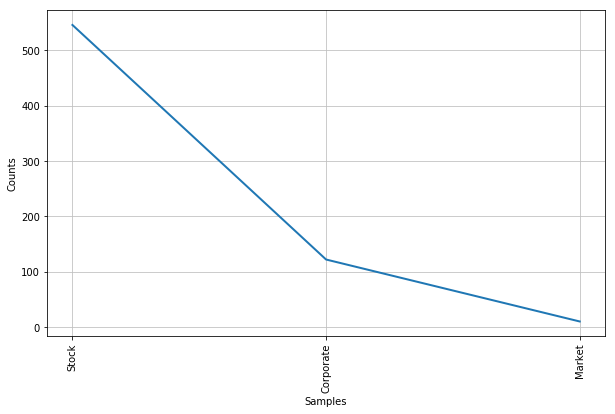

In [69]:
level0_freq = FreqDist(aspect_data['Level0'])
level0_freq.pprint()
level0_freq.plot()

dict_items([('Price Action', 379), ('Technical Analysis', 94), ('Options', 12), ('Volatility', 3), ('Sales', 19), ('Financial', 23), ('Coverage', 41), ('Fundamentals', 5), ('Dividend Policy', 13), ('Reputation', 2), ('Legal', 5), ('Strategy', 6), ('M&A', 11), ('Signal', 15), ('Rumors', 6), ('Risks', 28), ('Insider Activity', 2), ('Conditions', 1), ('Stategy', 6), ('Regulatory', 1)])


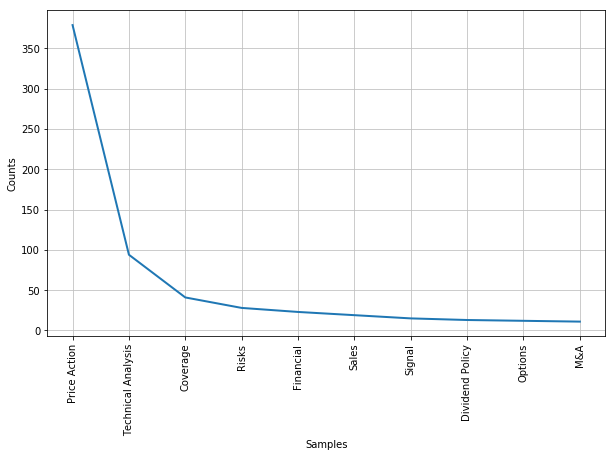

In [70]:
level1_freq = FreqDist(aspect_data['Level1'])
print(level1_freq.items())
level1_freq.plot(10)